In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

In [27]:
time_series_data = pd.read_csv('AirPassengers.csv')
# convert to numpy array
time_series_data = time_series_data['#Passengers'].values

In [28]:
time_series_data.shape

(144,)

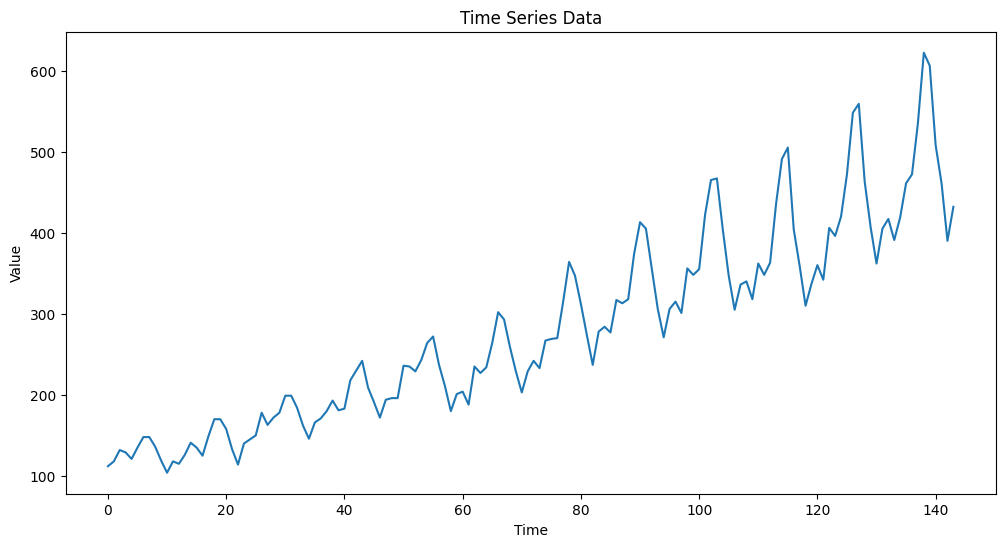

In [29]:
# Plot time series data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time_series_data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

In [30]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(time_series_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641


In [31]:
diff_data = np.diff(time_series_data)

In [32]:
result2 = adfuller(diff_data)
print(f'ADF Statistic: {result2[0]}')
print(f'p-value: {result2[1]}')

ADF Statistic: -2.8292668241699923
p-value: 0.054213290283826474


In [33]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler


def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def train_validate_test_split(data, train_size=0.7, val_size=0.15):
    n = len(data)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    return train_data, val_data, test_data

train_data, val_data, test_data = train_validate_test_split(diff_data)

scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1, 1))

train_data = scaler.transform(train_data.reshape(-1, 1)).flatten()
val_data = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()


In [34]:
sequence_length = 5  # Example sequence length

X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = X_train.reshape(-1, sequence_length, 1)
X_val = X_val.reshape(-1, sequence_length, 1)
X_test = X_test.reshape(-1, sequence_length, 1)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [35]:
import torch
import torch.nn as nn
from models import ElmanRNN

input_size = 1
hidden_size = 64  # Adjust as needed
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 64


In [36]:

from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [37]:
model = ElmanRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [38]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_losses.append(loss.item())
        model.train()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}')

In [39]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/20, Train Loss: 0.3210, Val Loss: 0.3310
Epoch 2/20, Train Loss: 0.2250, Val Loss: 0.2571
Epoch 3/20, Train Loss: 0.1486, Val Loss: 0.2026
Epoch 4/20, Train Loss: 0.0930, Val Loss: 0.1723
Epoch 5/20, Train Loss: 0.0636, Val Loss: 0.1714
Epoch 6/20, Train Loss: 0.0642, Val Loss: 0.1903
Epoch 7/20, Train Loss: 0.0799, Val Loss: 0.1991
Epoch 8/20, Train Loss: 0.0841, Val Loss: 0.1902
Epoch 9/20, Train Loss: 0.0750, Val Loss: 0.1763
Epoch 10/20, Train Loss: 0.0647, Val Loss: 0.1670
Epoch 11/20, Train Loss: 0.0598, Val Loss: 0.1638
Epoch 12/20, Train Loss: 0.0600, Val Loss: 0.1638
Epoch 13/20, Train Loss: 0.0622, Val Loss: 0.1645
Epoch 14/20, Train Loss: 0.0638, Val Loss: 0.1644
Epoch 15/20, Train Loss: 0.0638, Val Loss: 0.1633
Epoch 16/20, Train Loss: 0.0624, Val Loss: 0.1619
Epoch 17/20, Train Loss: 0.0604, Val Loss: 0.1608
Epoch 18/20, Train Loss: 0.0588, Val Loss: 0.1606
Epoch 19/20, Train Loss: 0.0580, Val Loss: 0.1613
Epoch 20/20, Train Loss: 0.0581, Val Loss: 0.1622


In [40]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)

predictions, actuals = predict(model, test_loader)

In [41]:
# Reshape for inverse transform
predictions = predictions.reshape(-1, 1)
actuals = actuals.reshape(-1, 1)

predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
print(f'Test MSE: {mse:.4f}, Test MAE: {mae:.4f}')


Test MSE: 2882.4792, Test MAE: 44.7765


In [43]:
actuals_inv.shape

(17, 1)

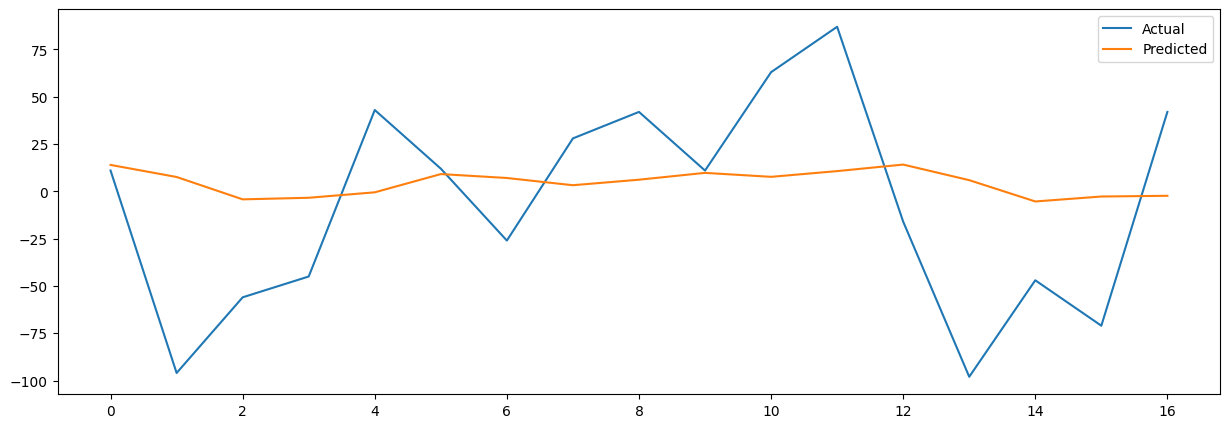

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(actuals_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.show()